In [1]:
# Description

# Requirements
import geopandas as gpd
import pathlib
from pathlib import Path

# Variables

gpkg_nld= Path.cwd().parent / "data" / "gadm" / "gadm41_NLD.gpkg"

In [2]:
# Read the GeoPackage file and the specified layer
gdf = gpd.read_file(gpkg_nld, layer='ADM_ADM_1')

gdf = gdf[~gdf['ENGTYPE_1'].str.contains("Water body")]

# Dissolve the polygons (you can specify a column to dissolve by, or just dissolve all)
dissolved = gdf.dissolve()

# Optionally, reset the index if needed
dissolved = dissolved.reset_index()

# Now, dissolved is a GeoDataFrame with dissolved polygons
#print(dissolved.head())


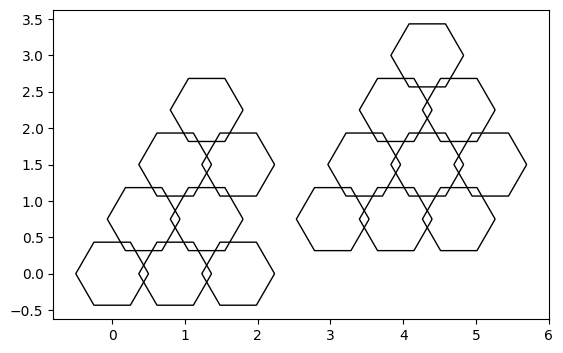

In [4]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import math

def create_hexagon(center_x, center_y, size):
    """Create a regular hexagon centered at (center_x, center_y) with given size (distance from center to any vertex)."""
    angles = [math.radians(angle) for angle in range(0, 360, 60)]
    points = [(center_x + size * math.cos(a), center_y + size * math.sin(a)) for a in angles]
    return Polygon(points)

def hexagonal_grid(multipolygon, hex_size):
    """Generate a hexagonal grid covering the multipolygon."""
    # Get bounds of the multipolygon
    minx, miny, maxx, maxy = multipolygon.bounds

    # Calculate width and height of a hexagon
    hex_height = 2 * hex_size
    hex_width = math.sqrt(3) * hex_size

    # Create a list for hexagons
    hexagons = []

    # Start creating hexagons row by row
    # Offset every second row by half the hex width
    y = miny
    row = 0
    while y < maxy + hex_height:
        x = minx - hex_width
        while x < maxx + hex_width:
            # Offset for every second row
            x_offset = (hex_width / 2) if (row % 2) else 0
            hexagon = create_hexagon(x + x_offset, y, hex_size)
            if hexagon.intersects(multipolygon):
                hexagons.append(hexagon)
            x += hex_width
        y += 3/4 * hex_height
        row += 1

    return gpd.GeoDataFrame(geometry=hexagons)

# Example usage:

# Suppose you have a multipolygon, for example:
from shapely.geometry import Polygon

poly1 = Polygon([(0, 0), (2, 0), (1, 2)])
poly2 = Polygon([(3, 1), (5, 1), (4, 3)])
multipolygon = MultiPolygon([poly1, poly2])

# Create hexagonal grid with hex size 0.5 units
hex_size = 0.5
hex_grid = hexagonal_grid(multipolygon, hex_size)

# Save or plot the result
hex_grid.plot(edgecolor='black', facecolor='none')
import matplotlib.pyplot as plt
plt.show()

In [ ]:
import h3pandas
resolution = 
hexagons = dissolved.h3.polyfill_resample(resolution)
hexagons.plot()

In [7]:
import math
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

# ------------------------------------------------------------------
# 1️⃣  Helper: create a single flat‑top hexagon centred at (x, y)
# ------------------------------------------------------------------
def regular_hexagon(center=(0, 0), size=1.0):
    """Return a Shapely Polygon for a regular hexagon."""
    cx, cy = center
    angles = [math.radians(a) for a in range(0, 360, 60)]  # 0°,60°,…,300°
    pts = [(cx + size * math.cos(a), cy + size * math.sin(a)) for a in angles]
    return Polygon(pts)


# ------------------------------------------------------------------
# 2️⃣  Helper: generate a rectangular lattice of hexagons that covers
#     a given bounding box.
# ------------------------------------------------------------------
def hex_grid(bounds, hex_size):
    """
    Produce a list of hexagon Polygons that tile the rectangle defined by
    ``bounds = (minx, miny, maxx, maxy)``.
    """
    minx, miny, maxx, maxy = bounds
    horiz = 3 * hex_size                     # centre‑to‑centre distance horizontally
    vert  = math.sqrt(3) * hex_size          # vertical step between rows

    hexes = []
    row = 0
    y = miny
    while y <= maxy + vert:
        # offset every other row by half a horizontal step
        x_offset = (row % 2) * 1.5 * hex_size
        x = minx + x_offset
        while x <= maxx + horiz:
            hexes.append(regular_hexagon((x, y), hex_size))
            x += horiz
        y += vert
        row += 1
    return hexes


# ------------------------------------------------------------------
# 3️⃣  Core routine: clip a hexagonal grid to a (multi)polygon.
# ------------------------------------------------------------------
def hexes_for_geometry(geom, hex_size):
    """
    Return a GeoSeries of hexagons that intersect ``geom``.
    ``geom`` may be a Polygon or MultiPolygon.
    """
    # 1️⃣ Get a bounding box that definitely contains the geometry
    bounds = geom.bounds                     # (minx, miny, maxx, maxy)

    # 2️⃣ Build a dense enough candidate grid
    candidates = hex_grid(bounds, hex_size)

    # 3️⃣ Keep only those that intersect the target geometry
    clipped = [h.intersection(geom) for h in candidates if h.intersects(geom)]

    # 4️⃣ Return as a GeoSeries (preserves CRS)
    return gpd.GeoSeries(clipped, crs=dissolved.crs)


# ------------------------------------------------------------------
# 4️⃣  Apply the routine to every row of your existing GeoDataFrame.
# ------------------------------------------------------------------
def hexify_geodf(gdf, hex_size):
    """
    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        Must contain a ``geometry`` column (Polygon or MultiPolygon).
    hex_size : float
        Desired side length / radius of the hexagons (same units as the CRS).

    Returns
    -------
    geopandas.GeoDataFrame
        One row per hexagon, inheriting the original CRS.
    """
    hex_gdfs = []               # will hold a list of GeoDataFrames

    for idx, row in gdf.iterrows():
        geom = row.geometry

        # Ensure we are dealing with a MultiPolygon for uniformity
        if isinstance(geom, Polygon):
            geom = MultiPolygon([geom])

        # Generate hexes for this particular geometry
        hex_series = hexes_for_geometry(geom, hex_size)

        # Optional: keep a reference to the original feature (e.g., an ID)
        # Here we just attach the original index; change as needed.
        hex_gdf = gpd.GeoDataFrame(
            {"orig_index": idx},
            geometry=hex_series,
            crs=gdf.crs,
        )
        hex_gdfs.append(hex_gdf)

    # Concatenate all per‑feature hex collections into one GeoDataFrame
    return gpd.GeoDataFrame(pd.concat(hex_gdfs, ignore_index=True), crs=gdf.crs)


# ------------------------------------------------------------------
# 5️⃣  Run it on your existing ``dissolved`` GeoDataFrame
# ------------------------------------------------------------------
# Choose a hex size that makes sense for the coordinate system.
#   • If you are in a geographic CRS (degrees), a value like 0.01 ≈ 1 km at the equator.
#   • If you are in a projected/metre CRS, use metres directly (e.g., 500 for 500 m hexagons).
hex_side_length = 0.01   # adjust to your needs

hex_gdf = hexify_geodf(dissolved, hex_side_length)

# ------------------------------------------------------------------
# 6️⃣  Quick visual check (optional)
# ------------------------------------------------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
# Plot the original dissolved polygons in a light colour
dissolved.boundary.plot(ax=ax, color="gray")
# Plot the generated hexagons
hex_gdf.plot(ax=ax, cmap="viridis", edgecolor="black", linewidth=0.3)
ax.set_aspect("equal")
plt.title("Hexagonal tiling of the dissolved geometries")
plt.show()

KeyboardInterrupt: 

In [ ]:
hex_gdf.to_file("hexagonTest.geojson", driver='GeoJSON')

In [ ]:
# Simplify and write geojson
# Simplify geometries with a tolerance (in units of the CRS)
# The higher the tolerance, the more simplified the geometry
tolerance = 0.001  # Adjust as needed
hexagons['geometry'] = hexagons['geometry'].simplify(tolerance)


# Write hexagon 
if(os.path.isfile("hexagonNetherlands.geojson")):
    os.remove("hexagonNetherlands.geojson")
    print("File Deleted successfully")
else:
    print("File does not exist")

hexagons.to_file("hexagonNetherlands.geojson", driver='GeoJSON')
